In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/eurosat_advanced.ipynb)

In this advanced example we are going to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset exploring the different features of Pytorch EO. In the simple example we saw how to train a model on the RGB version of EuroSAT. Here, we are going to use the full Sentinel 2 images.

In [2]:
from pytorch_eo.datasets.eurosat import EuroSATRGB, EuroSAT
from pytorch_eo.utils.sensors import S2

# RGB variant
#ds = EuroSATRGB(batch_size=25, verbose=True)

# MS variant, choose one band or a combination of bands
# you can use the RGB and ALL shortcuts 
#ds = EuroSAT(batch_size=25, bands=S2.RGB, verbose=True)
#ds = EuroSAT(batch_size=25, bands=[S2.B04, S2.B03, S2.B02], verbose=True)
#ds = EuroSAT(batch_size=25, bands=[S2.nir1, S2.green, S2.blue], verbose=True) # false color
#ds = EuroSAT(batch_size=25, bands=S2.B01, verbose=True) 
#ds = EuroSAT(batch_size=25, bands=S2.ALL, verbose=True) 
#ds = EuroSAT(batch_size=25, verbose=True, norm_value=(2**16-1)) 
ds = EuroSAT(batch_size=25, verbose=True) 

ds.setup()

data already extracted !
Number of images: 27000
training samples 16200
validation samples 5400
test samples 5400


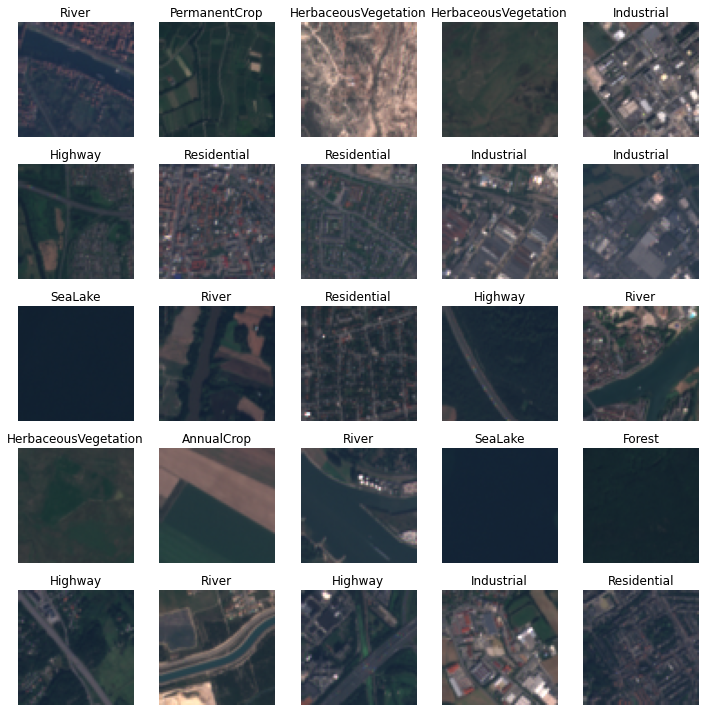

In [3]:
import matplotlib.pyplot as plt

imgs, labels = next(iter(ds.train_dataloader()))

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim < 3:
        ax.imshow(img, cmap="gray")
    else:
        if img.size(0) == 3:
            ax.imshow(img.permute(1,2,0))
        else:
            ax.imshow(img.permute(1,2,0)[...,(3,2,1)])
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

The dataset has multiple objects that we can use to inspect the data: images and labels are lists with the images paths and the ground trugh; train_idxs, val_idxs, test_idxs contain the indexes of the train, validation and test splits; classes is the list of classes (the label is the index in the list).

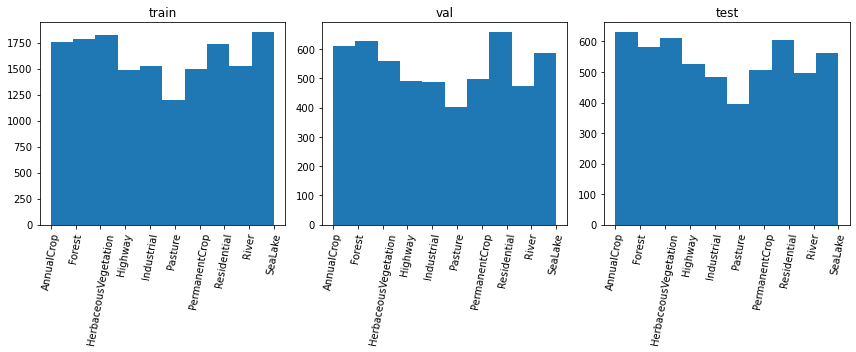

In [4]:
# label distribution

import numpy as np 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1,3,1)
ax.hist(np.array(ds.labels)[ds.train_idxs], bins=len(ds.classes))
ax.set_title('train')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,2)
ax.hist(np.array(ds.labels)[ds.val_idxs], bins=len(ds.classes))
ax.set_title('val')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,3)
ax.hist(np.array(ds.labels)[ds.test_idxs], bins=len(ds.classes))
ax.set_title('test')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
plt.tight_layout()
plt.show()

In the simple example we used `timm` to use a `resnet18` as a model. Here, we are going to build our own neural network using `torchvision`.

In [5]:
import torchvision
import torch

class MyModel(torch.nn.Module):
    def __init__(self, pretrained, num_classes, trans):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=pretrained)
        self.backbone = torch.nn.Sequential(*list(resnet.children())[:-2])
        self.fc = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(512, num_classes)
        )
        self.trans = trans
        
    def forward(self, x):
        x = self.trans(x)
        f = self.backbone(x)
        return self.fc(f)

We will also use data augmentation.

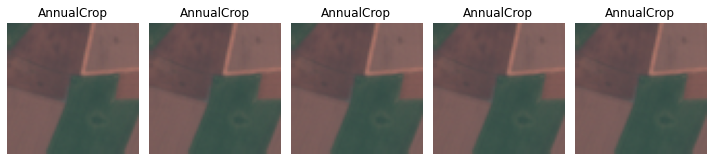

In [6]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip

trans = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5)
])

# create a batch with the same image
img, label = ds.ds[0] # first image in dataset
imgs = torch.stack(5*[img]) # repeat 5 tiemes
output = trans(imgs) # apply transforms

# visualize (run multiple times to see changes)
fig = plt.figure(figsize=(10, 10))
for i, img in enumerate(output):
    ax = plt.subplot(1, 5, i + 1)
    if img.ndim < 3:
        ax.imshow(img, cmap="gray")
    else:
        if img.size(0) == 3:
            ax.imshow(img.permute(1,2,0))
        else:
            ax.imshow(img.permute(1,2,0)[...,(3,2,1)])
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Besides the `model` we can define hyperparameters in the `hparams` object as well as `metrics`.

In [7]:
import pytorch_lightning as pl
from pytorch_eo.tasks.classification import ImageClassification
from pytorch_eo.metrics.classification import accuracy

ds = EuroSATRGB(batch_size=1024)

model =  MyModel(pretrained=True, num_classes=ds.num_classes, trans=trans)

hparams = {
    'loss': 'CrossEntropyLoss',
    'optimizer': 'SGD',
    'optim_params': {
        'lr': 1e-3,
        'momentum': 0.9,
        'weight_decay': 1e-2
    },
    'scheduler': 'StepLR',
    'scheduler_params': {
        'step_size': 3,
        'gamma': 0.1,
        'verbose': True
    }
}

metrics = {'acc': accuracy} 

task = ImageClassification(model, hparams, metrics)

We use Pytorch Lightning for training.

In [8]:
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=10,
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MyModel          | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-03.


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Adjusting learning rate of group 0 to 1.0000e-03.


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [ ]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9185185432434082, 'test_loss': 0.3368748426437378}
--------------------------------------------------------------------------------


[{'test_acc': 0.9185185432434082, 'test_loss': 0.3368748426437378}]

You can check your logs with Tensorboard (by default) or with any other logger supported in Pytorch Lightning.